# Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# Plot figures
%matplotlib inline
import matplotlib        as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




# save figures
ROOT_DIR = "."
DIR      = "kmean"
FIG_PATH = os.path.join(ROOT_DIR, "images", DIR)

os.makedirs(FIG_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(os.path.join(FIG_PATH, fig_id + "." + fig_extension),\
                bbox_inches='tight',\
                pad_inches=0.09,\
                format=fig_extension,\
                dpi=resolution)



# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## **Introduction – Classification _vs_ Clustering**

**- Although most of the applications of Machine Learning today are based on supervised learning (and as a result, this is where most of the investments go to), the vast majority of the available data is unlabeled: we have the input features X, but we do not have the labels y.**

**- The computer scientist Yann LeCun famously said that “if intelligence was a cake, unsupervised learning would be the cake, supervised learning would be the icing on the cake, and reinforcement learning would be the cherry on the cake.”**

**- In other words, there is a huge potential in unsupervised learning that we have only barely started to sink our teeth into.**

**A few more unsupervised learning tasks and algorithms:**

**Clustering**
The goal is to group similar instances together into clusters. Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.

**Anomaly detection**
The objective is to learn what “normal” data looks like, and then use that to detect abnormal instances, such as defective items on a production line or a new trend in a time series.

**Density estimation**
This is the task of estimating the probability density function (PDF) of the random process that generated the dataset. Density estimation is commonly used for anomaly detection: instances located in very low-density regions are likely to be anomalies. It is also useful for data analysis and visualization.

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
# Load data
data = load_iris()
X    = data.data
y    = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

# **K-Mean**

Let's start by generating some blobs:

In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
# Centers of 05 blobs
blob_centers = np.array(
                         [[ 0.2,  2.3],
                          [-1.5 ,  2.3],
                          [-2.8,  1.8],
                          [-2.8,  2.8],
                          [-2.8,  1.3]]
                        )

# Standard deviations
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [ ]:
# Make 05 blobs
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

print( 'Data of 5 blobs:' )
print( X.shape )
print( X)

print()
print( 'Labels of 5 blobs' )
print( y.shape )
print( y )


Data of 5 blobs:
(2000, 2)
[[-2.69823941  1.3454702 ]
 [-2.87459835  1.8097575 ]
 [ 0.96077126  1.17046777]
 ...
 [-2.80303543  2.72948115]
 [ 0.24057359  2.40103109]
 [-2.63807768  1.95621065]]

Labels of 5 blobs
(2000,)
[4 2 0 ... 3 0 2]


Now let's plot them:

In [ ]:
# For plotting clusters
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=2)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


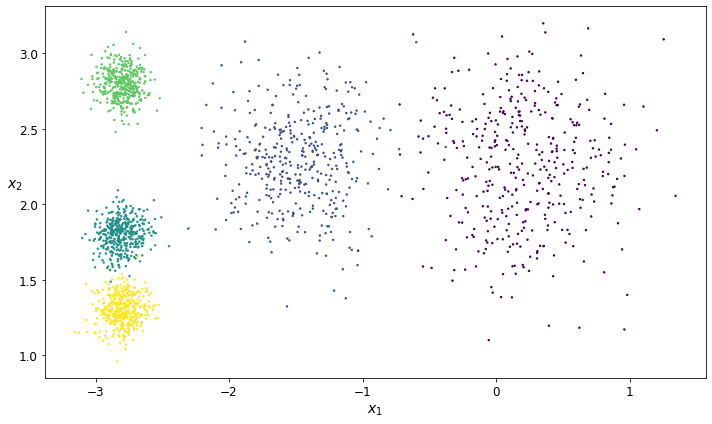

In [ ]:
# Plot figure
plt.figure(figsize=(10, 6))
plot_clusters(X, y)
save_fig("blobs_plot")
plt.show()

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)                 # Training and then predict

Each instance was assigned to one of the 5 clusters:

In [ ]:
# the prediction
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

In [ ]:
print( 'kmeans.labels_ :')
print(kmeans.labels_)

print()
print('Check: ')
y_pred is kmeans.labels_

kmeans.labels_ :
[4 1 0 ... 3 0 1]

Check: 


True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [ ]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [ ]:
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

We can predict the labels of new instances:

In [ ]:
# 4 new data points
X_new = np.array([
                  [0, 2],
                  [3, 2],
                  [-3, 3],
                  [-3, 2.5]
                 ])
# Predict the cluster of each new data point
results = kmeans.predict(X_new)

for Xi, res in zip(X_new, results):
  print( Xi, 'in cluster: ', res )

[0. 2.] in cluster:  0
[3. 2.] in cluster:  0
[-3.  3.] in cluster:  3
[-3.   2.5] in cluster:  3


### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    plot_data(X)
    
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


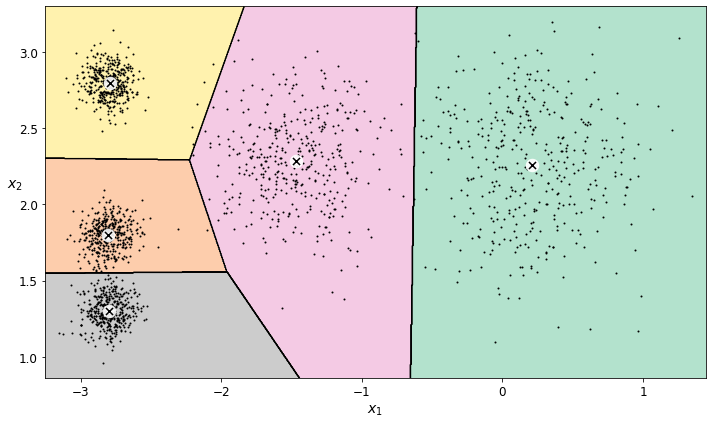

In [ ]:
# Figure
plt.figure(figsize=(10, 6))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.

Indeed, the K-Means algorithm does not behave very well when the blobs have very different diameters because all it cares about when assigning an instance to a cluster is the distance to the centroid.

### Hard Clustering _vs_ Soft Clustering

Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful to give each instance a score per cluster, which is called soft clustering. The score can be the distance between the instance and the centroid; conversely, it can be a similarity score (or affinity), such as the Gaussian Radial Basis Function. This is what the `transform()` method does:

In [ ]:
# The distances of the 4 new data points to 05 clusters
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

In this example, the first instance in X_new is located at a distance of 2.81 from the first centroid, 0.33 from the second centroid, 2.90 from the third centroid, 1.49 from the fourth centroid, and 2.89 from the fifth centroid. If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: this transformation can be a very efficient nonlinear dimensionality reduction technique.

This is indeed the Euclidian distance between each instance and each centroid:

In [ ]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [ ]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

Plot this:

Saving figure kmeans_algorithm_plot


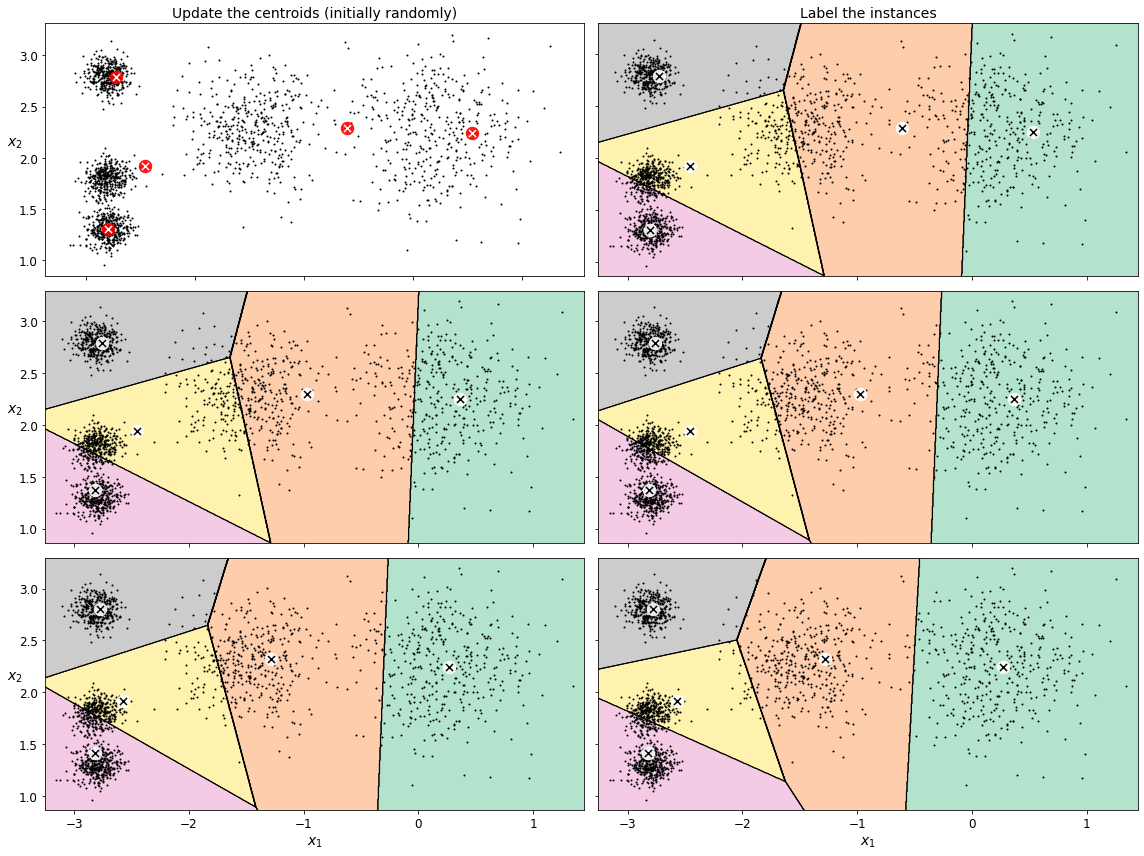

In [ ]:
plt.figure(figsize=(16, 12))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### **Centroid initialization methods (K-Means Variability)**

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [ ]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(14, 7))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


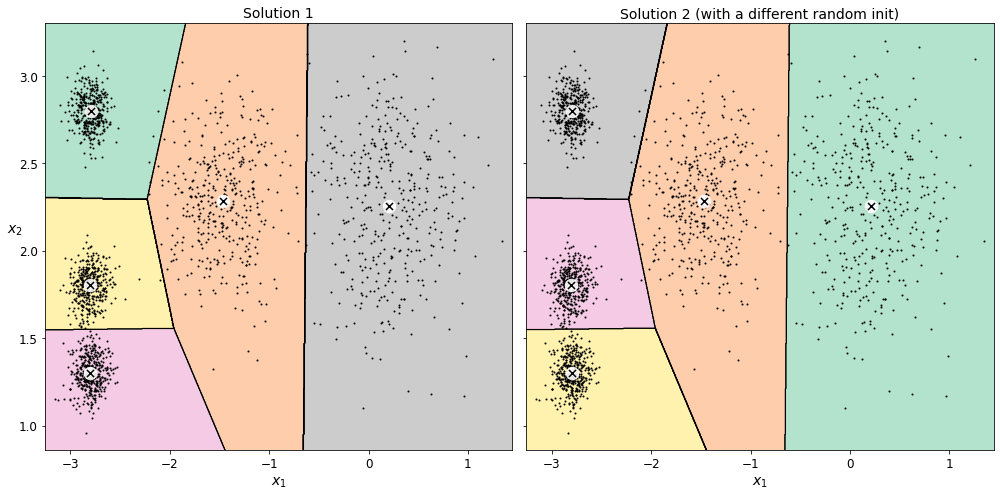

In [ ]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

If you happen to know approximately where the centroids should be (e.g., if you ran another clustering algorithm earlier), then you can set the init hyperparameter to a NumPy array containing the list of centroids, and set n_init to 1:

In [ ]:
# For example: Don't run this, just to illustrate
# good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
# kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution.

The number of random initializations is controlled by the n_init hyperparameter: by default, it is equal to 10, which means that the whole algorithm described earlier runs 10 times when you call fit(), and Scikit-Learn keeps the best solution.

But how exactly does it know which solution is the best? It uses a performance metric!

That metric is called the model’s `inertia`, which is the mean squared distance between each instance and its closest centroid.

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [ ]:
kmeans.inertia_

211.5985372581684

**As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid:**

In [ ]:
X_dist = kmeans.transform(X)
np.sum( X_dist[ np.arange(len(X_dist)), kmeans.labels_ ]**2 )

211.59853725816856

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "_great is better_" rule.

In [ ]:
kmeans.score(X)

-211.59853725816856

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [ ]:
kmeans_rnd_init1.inertia_

223.29108572819035

In [ ]:
kmeans_rnd_init2.inertia_

237.46249169442845

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [ ]:
#  runs the original algorithm 10 times,
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random",
                             n_init=10,
                             algorithm="full",
                             random_state=11)

# Training
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=11, tol=0.0001, verbose=0)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

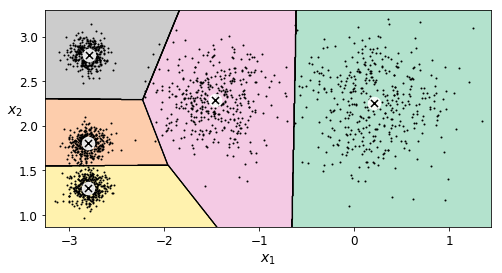

In [ ]:
plt.figure(figsize=(12, 6))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [ ]:
# Just to verify
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
# Kmeans model with init param
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

# Ineria : Sum of mean squared distances from each intance to the centroid
kmeans.inertia_

211.5985372581684

The KMeans class uses this initialization method by default. If you want to force it to use the original method (i.e., picking k instances randomly to define the initial centroids), then you can set the init hyperparameter to "random". You will rarely need to do this.

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [ ]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

83.7 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [ ]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

106 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini-Batch K-Means

Instead of using the full dataset at each iteration, the algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory. Scikit-Learn implements this algorithm in the MiniBatchKMeans class. You can just use this class like the KMeans class.

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
# K-Means with Mini-Batch
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [ ]:
# Ineria : Sum of mean squared distances from each intance to the centroid
minibatch_kmeans.inertia_

211.93186531476775

If the dataset does not fit in memory, the simplest option is to use the memmap class, as we did for incremental PCA. Alternatively, you can pass one mini-batch at a time to the partial_fit() method, but this will require much more work, since you will need to perform multiple initializations and select the best one yourself (see the example below).

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

In [ ]:
import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], random_state=42)

Next, let's write it to a `memmap`:

In [ ]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

If your data is so large that you cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [ ]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [ ]:
np.random.seed(42)

In [ ]:
# Number of clusters
k = 5

# Other params
n_init       = 10
n_iterations = 100
batch_size   = 100
init_size    = 500  # more data for K-Means++ initialization

evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [ ]:
# Best score or best inertia
best_kmeans.score(X)

-211.70999744411483

Mini-batch K-Means is much faster than regular K-Means:

In [ ]:
%timeit KMeans(n_clusters=5).fit(X)

47 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

26.2 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's *much* faster! However, its performance is often lower (higher inertia), and it keeps degrading as _k_ increases.

Although the Mini-batch K-Means algorithm is much faster than the regular K-Means algorithm, its inertia is generally slightly worse, especially as the number of clusters increases. You can see this in Figure 9-6: the plot on the left compares the inertias of Mini-batch K-Means and regular K-Means models trained on the previous dataset using various numbers of clusters k. The difference between the two curves remains fairly constant, but this difference becomes more and more significant as k increases, since the inertia becomes smaller and smaller. In the plot on the right, you can see that Mini-batch K-Means is much faster than regular K-Means, and this difference increases with k.


Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

In [ ]:
from timeit import timeit

In [ ]:
times    = np.empty((100, 2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_          = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    
    print("\r{}/{}".format(k, 100), end="")
    
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Saving figure minibatch_kmeans_vs_kmeans


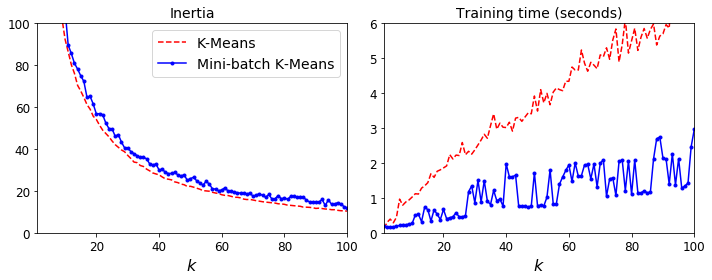

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### Finding the optimal number of clusters

So far, we have set the number of clusters k to 5 because it was obvious by looking at the data that this was the correct number of clusters. But in general, it will not be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value.

See the example below:

What if the number of clusters was set to a lower or greater value than 5?

Saving figure bad_n_clusters_plot


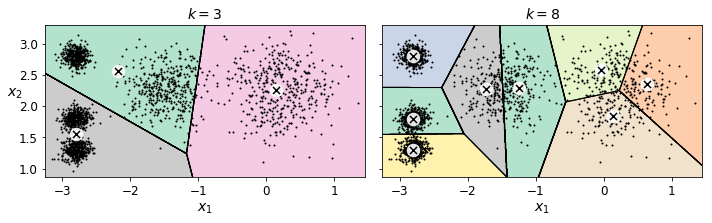

In [ ]:
# K-means with different number of clusters (here we don't know the actual number of clusters)
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

# Figure
plt.figure( figsize=(14, 7) )
plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [ ]:
# Model with k = 3 clusters
kmeans_k3.inertia_

653.2167190021553

In [ ]:
# Model with k = 8 clusters
kmeans_k8.inertia_

119.11983416102879

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [ ]:
# Kmeans with different number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

# And their inertias
inertias = [model.inertia_ for model in kmeans_per_k]

**You might be thinking that we could just pick the model with the lowest inertia, right? Unfortunately, it is not that simple. The inertia for k=3 is 653.2, which is much higher than for k=5 (which was 211.6). But with k=8, the inertia is just 119.1. The inertia is not a good performance metric when trying to choose k because it keeps getting lower as we increase k. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. Let’s plot the inertia as a function of k.**

Saving figure inertia_vs_k_diagram


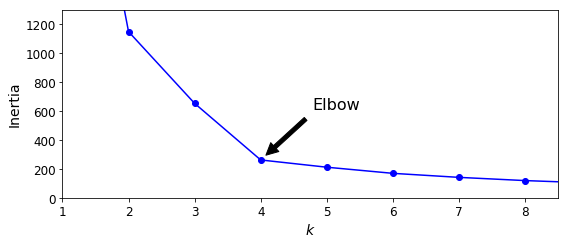

In [ ]:
# Plot inertia vs k (number of clusters)
plt.figure(figsize=(8, 3.5))

plt.plot(range(1, 10), inertias, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

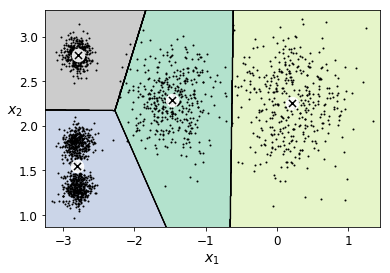

In [ ]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

**This technique for choosing the best value for the number of clusters is rather coarse. A more precise approach (but also more computationally expensive) is to use the silhouette score, which is the mean silhouette coefficient over all the instances. An instance’s silhouette coefficient is equal to  (b – a) / max(a, b), where a is the mean distance to the other instances in the same cluster (i.e., the mean intra-cluster distance) and b is the mean nearest-cluster distance (i.e., the mean distance to the instances of the next closest cluster, defined as the one that minimizes b, excluding the instance’s own cluster). The silhouette coefficient can vary between –1 and +1. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.**

## **silhouette score**

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances.

- An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster).

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [ ]:
# To compute the silhouette score, you can use Scikit-Learn’s silhouette_score() function,
# giving it all the instances in the dataset and the labels they were assigned:
from sklearn.metrics import silhouette_score

In [ ]:
# for kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
# The silhouette_score is:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [ ]:
# kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                # for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


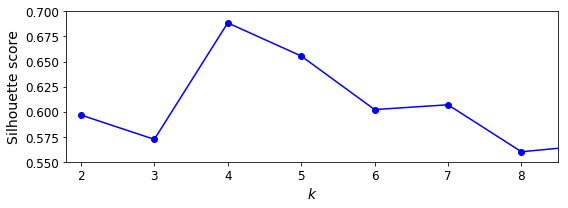

In [ ]:
# Plot results
plt.figure(figsize=(8, 3))

plt.plot(range(2, 10), silhouette_scores, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

plt.axis([1.8, 8.5, 0.55, 0.7])

save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

Saving figure silhouette_analysis_diagram


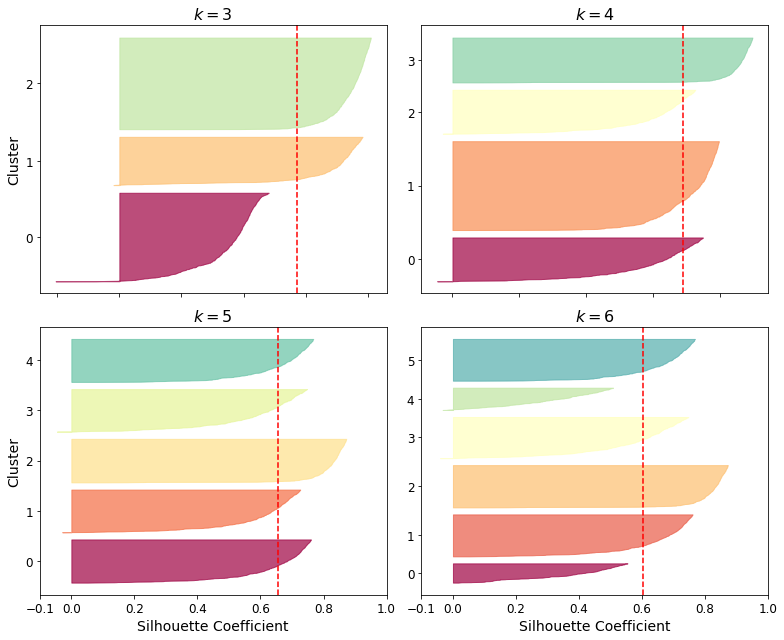

In [ ]:
from sklearn.metrics   import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(14, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

The vertical dashed lines represent the silhouette score for each number of clusters.

When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters.

We can see that when k = 3 and when k = 6, we get bad clusters. But when k = 4 or k = 5, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to 1.0. When k = 4, the cluster at index 1 (the third from the top) is rather big. When k = 5, all clusters have similar sizes.

So, even though the overall silhouette score from k = 4 is slightly greater than for k = 5, it seems like a good idea to use k = 5 to get clusters of similar sizes.

### Limits of K-Means

Despite its many merits, most notably being fast and scalable, K-Means is not perfect. As we saw, it is necessary to run the algorithm several times to avoid suboptimal solutions, plus you need to specify the number of clusters, which can be quite a hassle.

Moreover, K-Means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes. For example, Figure below shows how K-Means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities, and orientations.

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1     = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2     = X2 + [6, -8]

X = np.r_[X1, X2]
y = np.r_[y1, y2]

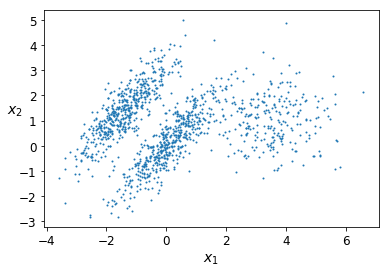

In [ ]:
plt.figure(figsize=(10, 6))
plot_clusters(X)
plt.show()

In [ ]:
# Sample models
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)

# Training
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Saving figure bad_kmeans_diagram


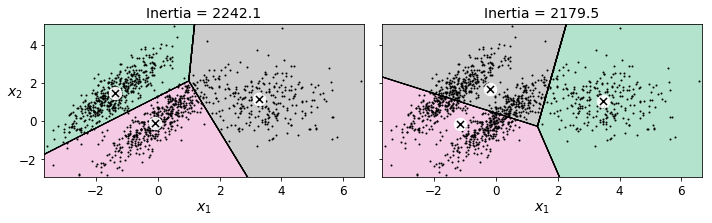

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

As you can see, neither of these solutions is any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right. The solution on the right is just terrible, even though its inertia is lower. So, depending on the data, different clustering algorithms may perform better. On these types of elliptical clusters, Gaussian mixture models work great.

**TIP:**

It is important to scale the input features before you run K-Means, or the clusters may be very stretched and K-Means will perform poorly. Scaling the features does not guarantee that all the clusters will be nice and spherical, but it generally improves things.

### **Using clustering for image segmentation**

Now let’s look at a few ways we can benefit from clustering. We will use K-Means, but feel free to experiment with other clustering algorithms.

In [ ]:
# Download the ladybug image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

In [ ]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [ ]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [ ]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


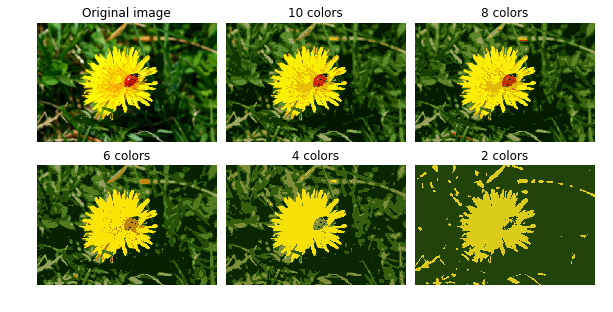

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Using Clustering for Preprocessing

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [ ]:
from sklearn.datasets import load_digits

In [ ]:
X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
log_reg.score(X_test, y_test)

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [ ]:
pipeline.score(X_test, y_test)

0.9777777777777777

In [ ]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

How about that? We reduced the error rate by over 28%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 13.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, ...penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kmeans__n_clusters': range(2, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Let's see what the best number of clusters is:

In [ ]:
grid_clf.best_params_

{'kmeans__n_clusters': 99}

In [ ]:
grid_clf.score(X_test, y_test)

0.9822222222222222

### **Clustering for Semi-supervised Learning**

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [ ]:
n_labeled = 50

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [ ]:
k = 50

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits  = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


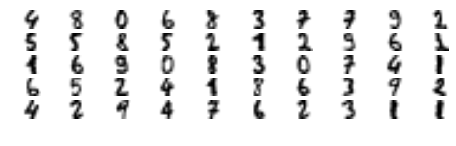

In [ ]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [ ]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

Wow! We jumped from 83.3% accuracy to 92.2%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
log_reg.score(X_test, y_test)

0.9333333333333333

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 20th percentile closest to the centroid:

In [ ]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster      = (kmeans.labels_ == i)
    cluster_dist    = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff    = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [ ]:
partially_propagated         = (X_cluster_dist != -1)

X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
# Train again
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# Test score
log_reg.score(X_test, y_test)

0.94

Nice! With just 50 labeled instances (just 5 examples per class on average!), we got 94% performance, which is pretty close to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is very close to 99%:

In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

## **Active Learning**

**To continue improving your model and your training set, the next step could be to do a few rounds of active learning, which is when a human expert interacts with the learning algorithm, providing labels for specific instances when the algorithm requests them. There are many different strategies for active learning, but one of the most common ones is called uncertainty sampling. Here is how it works:**

- The model is trained on the labeled instances gathered so far, and this model is used to make predictions on all the unlabeled instances.

- The instances for which the model is most uncertain (i.e., when its estimated probability is lowest) are given to the expert to be labeled.

- You iterate this process until the performance improvement stops being worth the labeling effort.

**Other strategies include labeling the instances that would result in the largest model change, or the largest drop in the model’s validation error, or the instances that different models disagree on (e.g., an SVM or a Random Forest).**